In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os

In [2]:
def converter(dBm):
    return 10**((dBm+90)/10)

In [3]:
#---------------------------Data Analysis--------------------------------------
#data file name is in structure of "label_attempt.json" (e.g "0_1.json"), each file contains a list of dictionaries {"MAC":mac, "RSSI":rssi}
#read through all files and create a set of MAC addresses that are in all files
num_labels = ['0_0','1_0','2_0','3_0','4_0','5_0','6_0','7_0']
num_attempts = 100
mac_set = set()
base_path = "data"
for label in num_labels:
    set_a = set()
    with open(os.path.join(base_path,f"{label}_0.json"), "r") as f:
        data = json.load(f)
        for item in data:
            item = json.loads(item)
            set_a.add(item["MAC"])
    for attempt in range(1,num_attempts):
        set_b = set()
        file_name = os.path.join(base_path,f"{label}_{attempt}.json")
        try:
            with open(file_name, "r") as f:
                data = json.load(f) #list of dictionaries
                for item in data:
                    item = json.loads(item) #make sure it's in dictionary format
                    set_b.add(item["MAC"])
        except: #file not found
            # print(f"File {file_name} not found")
            continue
        #find intersection of set_a and set_b
        set_a = set_a.intersection(set_b)
    #find union of set_a and mac_set
    mac_set = mac_set.union(set_a)
    
mac_set = list(mac_set)
print("Number of MAC addresses: ", len(mac_set))
#save mac_set to a file
with open(os.path.join(base_path,"mac_set.txt"), "w") as f:
    for mac in mac_set:
        f.write(mac + "\n")

Number of MAC addresses:  89


In [4]:
#---------------------------Data Preprocessing--------------------------------------
p_conv_table = {0: (0,-1), 1:(0,0), 2:(0,1), 3:(1,0), 4:(-1,0), 5:(-2,0), 6:(2,0), 7:(3,0)}


#read mac_set.txt and create a list
mac_set = []
with open(os.path.join(base_path,"mac_set.txt"), "r") as f:
    for line in f:
        mac_set.append(line.strip())

#data training set
data_set = []
#read through all files
for label in num_labels:
    for attempt in range(num_attempts):
        file_name = os.path.join(base_path, f"{label}_{attempt}.json")
        try:
            with open(file_name,"r") as f:
                data = json.load(f) #list of dictionary with mac, rssi
                #create a 0 vector with length of mac_set
                vector = np.full(len(mac_set),-100)
                #for each mac in data, find its index in mac_set and update the vector
                for item in data:
                    item = json.loads(item)
                    try:
                        index = mac_set.index(item["MAC"])
                    except ValueError: #mac not in mac_set
                        continue #skip!
                    vector[index] = item["RSSI"]
                position = p_conv_table[int(label[0])]
                data_set.append((position, vector))
        #except file not found
        except FileNotFoundError:
            # print(f"{file_name} not found")
            continue
        except:
            print("Error in file: ", file_name)

#data_set to dataframe
df = pd.DataFrame(data_set, columns=["label", "vector"])

In [5]:
df

,label,vector
0,"(0, -1)","[-100, -77, -100, -65, -100, -100, -88, -91, -..."
1,"(0, -1)","[-100, -80, -100, -74, -100, -100, -80, -87, -..."
2,"(0, -1)","[-100, -83, -100, -76, -100, -100, -86, -87, -..."
3,"(0, -1)","[-100, -87, -100, -76, -100, -100, -83, -86, -..."
4,"(0, -1)","[-100, -84, -100, -77, -100, -100, -81, -87, -..."
...,...,...
695,"(3, 0)","[-79, -100, -100, -90, -100, -85, -100, -100, ..."
696,"(3, 0)","[-79, -100, -100, -90, -100, -86, -100, -100, ..."
697,"(3, 0)","[-86, -100, -100, -88, -100, -85, -100, -100, ..."
698,"(3, 0)","[-79, -100, -100, -94, -100, -87, -100, -100, ..."


(array([4.1615e+04, 3.9700e+02, 1.3100e+02, 1.8400e+02, 0.0000e+00,
        1.5000e+01, 5.1000e+01, 5.8000e+01, 0.0000e+00, 4.6000e+01,
        0.0000e+00, 0.0000e+00, 8.1000e+01, 0.0000e+00, 0.0000e+00,
        1.0000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1000e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

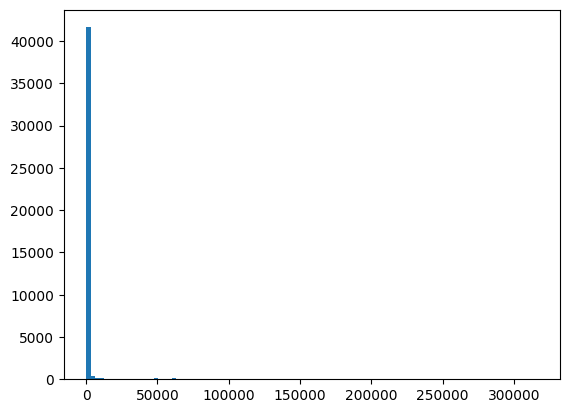

In [6]:
#plot histogram of element of vectors (i.e histogram of rssi values)
rssi_list = []
for label in num_labels:
    for attempt in range(num_attempts):
        file_name = os.path.join(base_path, f"{label}_{attempt}.json")
        try:
            with open(file_name,"r") as f:
                data = json.load(f) #list of dictionary with mac, rssi
                for item in data:
                    item = json.loads(item)
                    rssi_list.append(converter(item["RSSI"]))
        except FileNotFoundError:
            # print(f"{file_name} not found")
            continue
        except:
            print("Error in file: ", file_name)
#most values are between 0 and 1
plt.hist(rssi_list, bins=100)

In [7]:
#---------------------------Data Visualization--------------------------------------
#vector is len(mac_set) long, which is a large dimension. So let's use auto encoder to reduce the dimension and visualize the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#standardize the data
scaler = StandardScaler()
vec = df["vector"].values.tolist()
scaled_data = scaler.fit_transform(vec)

#PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)

#plot 3d
x = pca_data[:,0]
y = pca_data[:,1]
z = pca_data[:,2]

#plotly
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_3d(x=x, y=y, z=z, color=df["label"])
fig.show()

In [8]:
#---------------------------Model Training--------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

multi_output_regressor = MultiOutputRegressor(RandomForestRegressor(random_state=0))

#split data
X = df["vector"].values.tolist()
y = df["label"].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#train knn model
multi_output_regressor.fit(X_train, y_train)
pred = multi_output_regressor.predict(X_test)

#convert pred to a tuple
pred = [tuple(x) for x in pred]

#calculate error
error = mean_squared_error(y_test, pred)
print("Error: ", error)

NameError: name 'train_test_split' is not defined

In [ ]:
#---------------------------Predict Visualization--------------------------------------
#plot confusion matrix
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# #confusion matrix
# cm = confusion_matrix(y_test, pred)
# #plot
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True)
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

[ 0. -1.]
[ 0.   -0.02]
[0. 1.]
[ 0.   -0.01]
[-1.  0.]
[-2.  0.]
[-1.06  0.  ]
[ 0.07 -0.01]
[0.96 0.  ]
[2. 0.]
[2.99 0.  ]


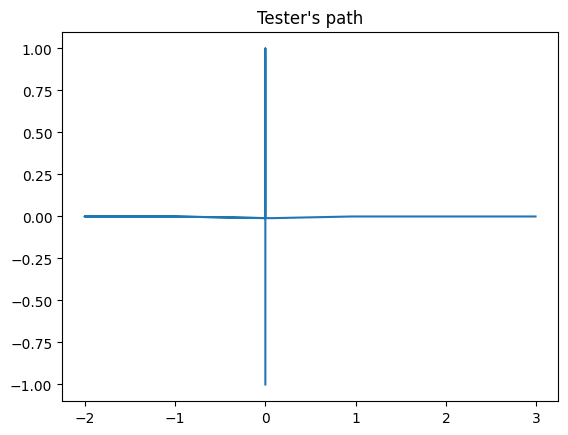

In [ ]:
from client import Client

test_subject = Client("Tester")

test_data = X_test #make a copy
test_label = y_test #make a copy

#data frame with X_test column and y_test column
df = pd.DataFrame()
df["vector"] = test_data
df["label"] = test_label

client_path = [0,1,2,1,4,5,4,1,3,6,7] #ground truth!
#get random samples of test_data with the label in order of client_path labels
for label in client_path:
    #get a random sample of test_data with label
    position = p_conv_table[label]
    sample = df[df["label"] == position].sample()
    vector = sample["vector"].values.tolist()[0]
    test_subject.put_vector(vector)

predicted_path = []
for pos in range(len(test_subject.path)):
    #get the vector
    vector = test_subject.get_vector(pos)
    #predict the label
    pred = multi_output_regressor.predict([vector])
    print(pred[0])
    #from np array to int
    predicted_path.append(pred[0])

test_subject.plot_path(predicted_path)


In [ ]:
sample = df[df["label"] == position].sample()

In [ ]:
type(sample["vector"].values.tolist()[0])

numpy.ndarray